# A tutorial on how "BatchSize" Controls Noise, Stability, and Convergence in Gradient Descent.

### 1. Import and Setup
* Import packages that are required.
* Import the frameworks that are required. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 2. Load the Dataset. 

Load the  credit card dataset downloaded from kaggle. 

In [11]:
data_path = "creditcard.csv" 
df = pd.read_csv(data_path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
print("Shape:", df.shape)
print(df.describe().T.head())

Shape: (284807, 31)
         count          mean           std        min           25%  \
Time  284807.0  9.481386e+04  47488.145955   0.000000  54201.500000   
V1    284807.0  1.168375e-15      1.958696 -56.407510     -0.920373   
V2    284807.0  3.416908e-16      1.651309 -72.715728     -0.598550   
V3    284807.0 -1.379537e-15      1.516255 -48.325589     -0.890365   
V4    284807.0  2.074095e-15      1.415869  -5.683171     -0.848640   

               50%            75%            max  
Time  84692.000000  139320.500000  172792.000000  
V1        0.018109       1.315642       2.454930  
V2        0.065486       0.803724      22.057729  
V3        0.179846       1.027196       9.382558  
V4       -0.019847       0.743341      16.875344  


### 3. Class Distribution & Basic Visualisation

This dataset is highly imbalanced: Class = 1 is fraud.

Class
0    284315
1       492
Name: count, dtype: int64


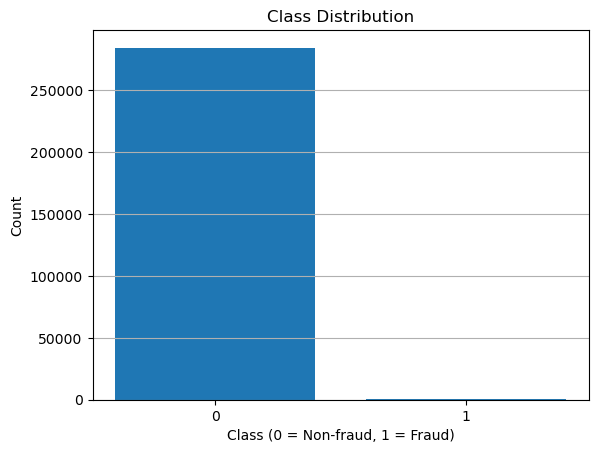

Fraud cases ratio: 0.001727 (~0.1727%)


In [16]:
class_counts = df["Class"].value_counts().sort_index()
print(class_counts)

plt.figure()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.xlabel("Class (0 = Non-fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.grid(axis="y")
plt.show()

fraud_ratio = class_counts[1] / class_counts.sum()
print(f"Fraud cases ratio: {fraud_ratio:.6f} (~{fraud_ratio*100:.4f}%)")

### 4. Train/Validation/Test Split + Preprocessing

Features:

*V1..V28 already PCA-like

*Amount and Time need scaling

Target:
Class

In [23]:
# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"].values

# Train + temp split first
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Then split temp into validation + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print("Train shape:", X_train_full.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (199364, 30)
Val shape: (42721, 30)
Test shape: (42722, 30)


### Scale Amount and Time

In [27]:
scaler = StandardScaler()

# Copy to avoid modifying original
X_train = X_train_full.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Columns to scale
cols_to_scale = ["Time", "Amount"]

# Fit scaler on train, apply to all splits
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_val_scaled[cols_to_scale] = scaler.transform(X_val_scaled[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test_scaled[cols_to_scale])

X_train = X_train.values
X_val_scaled = X_val_scaled.values
X_test_scaled = X_test_scaled.values

print("Feature shape:", X_train.shape[1])

Feature shape: 30


### 5. Handle Class Imbalance with Class Weights

Because fraud cases are very rare, we’ll use class weights.

In [30]:
from collections import Counter

counter = Counter(y_train_full)
print("Training class counts:", counter)

# Simple class weight: inverse frequency
total = len(y_train_full)
weight_for_0 = total / (2.0 * counter[0])
weight_for_1 = total / (2.0 * counter[1])

class_weight = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weight)

Training class counts: Counter({0: 199020, 1: 344})
Class weights: {0: 0.5008642347502763, 1: 289.7732558139535}


### 6. Build the Model (Keras MLP)

We’ll define a small MLP for tabular data and reuse it for each batch size.

In [33]:
input_dim = X_train.shape[1]

def build_model():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc")
        ]
    )
    return model

model_example = build_model()
model_example.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

### 7.Training with Different Batch Sizes

We’ll train separate models with different batch sizes and compare:

In [36]:
BATCH_SIZES = [16, 64, 256, 1024]
EPOCHS = 15

histories = {}
test_results = {}

for bs in BATCH_SIZES:
    print(f"\n=== Training with batch size = {bs} ===")
    model = build_model()
    
    history = model.fit(
        X_train, y_train_full,
        validation_data=(X_val_scaled, y_val),
        epochs=EPOCHS,
        batch_size=bs,
        class_weight=class_weight,
        verbose=1
    )
    
    # Save history
    histories[bs] = history.history
    
    # Evaluate on test set
    y_pred_proba = model.predict(X_test_scaled).ravel()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    test_acc = np.mean(y_pred == y_test)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    
    test_results[bs] = {
        "accuracy": test_acc,
        "auc": test_auc
    }
    
    print(f"Test Accuracy (bs={bs}): {test_acc:.4f}, Test AUC: {test_auc:.4f}")



=== Training with batch size = 16 ===
Epoch 1/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9779 - auc: 0.9499 - loss: 0.2779 - val_accuracy: 0.9571 - val_auc: 0.9796 - val_loss: 0.1543
Epoch 2/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9770 - auc: 0.9840 - loss: 0.1415 - val_accuracy: 0.9637 - val_auc: 0.9774 - val_loss: 0.1302
Epoch 3/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9757 - auc: 0.9897 - loss: 0.1169 - val_accuracy: 0.9647 - val_auc: 0.9789 - val_loss: 0.0965
Epoch 4/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9780 - auc: 0.9927 - loss: 0.1054 - val_accuracy: 0.9617 - val_auc: 0.9783 - val_loss: 0.1033
Epoch 5/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9743 - auc: 0.9944 - loss: 0.0938 - val_accuracy: 0.9598 - val_auc: 0.9768 - val_loss: 0.1020
Epoch 6/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9759 - auc: 0.9953 - loss: 0.0867 - val_accuracy: 0.9664 - val_au

### 8. Compare Test Results Across Batch Sizes.

In [39]:
print("\n=== Test Results by Batch Size ===")
for bs, res in test_results.items():
    print(f"Batch size {bs}: Accuracy = {res['accuracy']:.4f}, AUC = {res['auc']:.4f}")


=== Test Results by Batch Size ===
Batch size 16: Accuracy = 0.9399, AUC = 0.9768
Batch size 64: Accuracy = 0.9796, AUC = 0.9764
Batch size 256: Accuracy = 0.9812, AUC = 0.9723
Batch size 1024: Accuracy = 0.9821, AUC = 0.9747


### 9. Visualise Learning Curves (Loss & AUC)
Plot Loss vs Epoch for all batch sizes

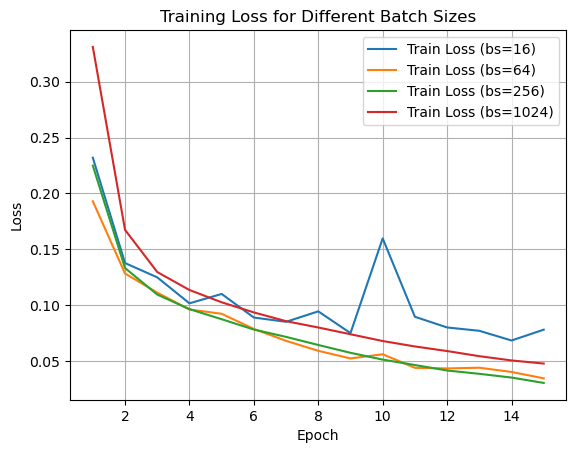

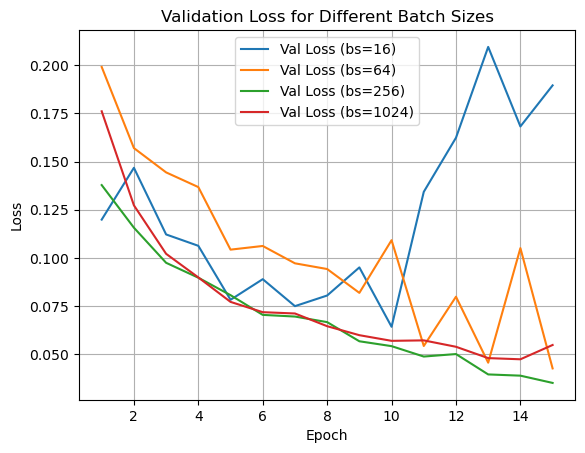

In [62]:
epochs = range(1, EPOCHS + 1)

plt.figure()
for bs in BATCH_SIZES:
    plt.plot(epochs, histories[bs]["loss"], label=f"Train Loss (bs={bs})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Batch Sizes")
plt.legend()
plt.grid(True)
plt.savefig("TrainingLoss_forDiffBatchSizes.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
for bs in BATCH_SIZES:
    plt.plot(epochs, histories[bs]["val_loss"], label=f"Val Loss (bs={bs})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss for Different Batch Sizes")
plt.legend()
plt.grid(True)
plt.savefig("ValidationLoss_forDiffBatchSizes.png", dpi=300, bbox_inches="tight")
plt.show()

### Plot AUC vs Epoch

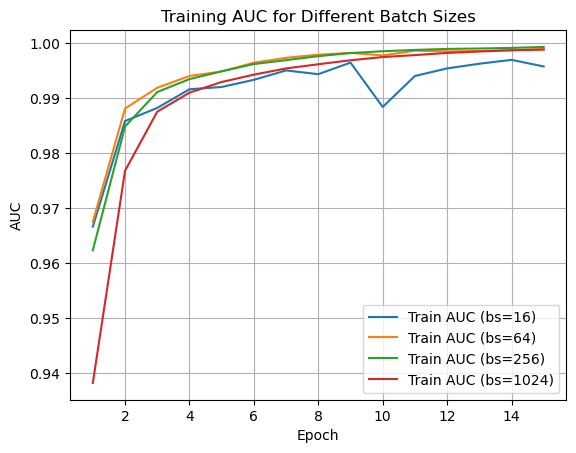

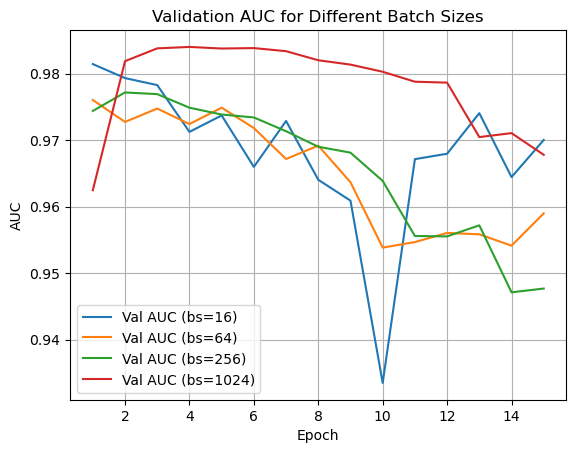

In [60]:
plt.figure()
for bs in BATCH_SIZES:
    plt.plot(epochs, histories[bs]["auc"], label=f"Train AUC (bs={bs})")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training AUC for Different Batch Sizes")
plt.legend()
plt.grid(True)
plt.savefig("Training_AUC_forDiffBatchSizes.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
for bs in BATCH_SIZES:
    plt.plot(epochs, histories[bs]["val_auc"], label=f"Val AUC (bs={bs})")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Validation AUC for Different Batch Sizes")
plt.legend()
plt.grid(True)
plt.savefig("Validation_AUC_forDiffBatchSizes.png", dpi=300, bbox_inches="tight")
plt.show()

### 10. Modify your training loop to save the trained models

In [52]:
models = {}     # store trained models
histories = {}
test_results = {}

for bs in BATCH_SIZES:
    print(f"\n=== Training with batch size = {bs} ===")
    model = build_model()
    
    history = model.fit(
        X_train, y_train_full,
        validation_data=(X_val_scaled, y_val),
        epochs=EPOCHS,
        batch_size=bs,
        class_weight=class_weight,
        verbose=1
    )
    
    histories[bs] = history.history
    models[bs] = model   # save trained model
    
    # Evaluate
    y_pred_proba = model.predict(X_test_scaled).ravel()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    test_acc = np.mean(y_pred == y_test)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    
    test_results[bs] = {"accuracy": test_acc, "auc": test_auc}

    print(f"Test Accuracy (bs={bs}): {test_acc:.4f}, Test AUC: {test_auc:.4f}")



=== Training with batch size = 16 ===
Epoch 1/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9763 - auc: 0.9667 - loss: 0.2320 - val_accuracy: 0.9742 - val_auc: 0.9815 - val_loss: 0.1199
Epoch 2/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9784 - auc: 0.9859 - loss: 0.1377 - val_accuracy: 0.9601 - val_auc: 0.9793 - val_loss: 0.1468
Epoch 3/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9773 - auc: 0.9883 - loss: 0.1249 - val_accuracy: 0.9706 - val_auc: 0.9783 - val_loss: 0.1122
Epoch 4/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.9809 - auc: 0.9917 - loss: 0.1017 - val_accuracy: 0.9673 - val_auc: 0.9713 - val_loss: 0.1063
Epoch 5/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9802 - auc: 0.9921 - loss: 0.1101 - val_accuracy: 0.9792 - val_auc: 0.9737 - val_loss: 0.0783
Epoch 6/15
12461/12461 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9817 - auc: 0.9934 - loss: 0.0890 - val_accuracy: 0.9688 - val_au

### 11. Generate Confusion Matrices WITHOUT Retraining.

In [55]:
from sklearn.metrics import confusion_matrix

# Choose smallest and largest batch size
bs_small = BATCH_SIZES[0]
bs_large = BATCH_SIZES[-1]

# Get predictions directly from saved models
y_pred_small = (models[bs_small].predict(X_test_scaled).ravel() >= 0.5).astype(int)
y_pred_large = (models[bs_large].predict(X_test_scaled).ravel() >= 0.5).astype(int)

# Confusion matrices
cm_small = confusion_matrix(y_test, y_pred_small)
cm_large = confusion_matrix(y_test, y_pred_large)

print("Confusion matrix (small batch size):")
print(cm_small)

print("\nConfusion matrix (large batch size):")
print(cm_large)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step
Confusion matrix (small batch size):
[[40034  2614]
 [    6    68]]

Confusion matrix (large batch size):
[[42025   623]
 [   10    64]]


### 12. Visualise Confusion Matrices.

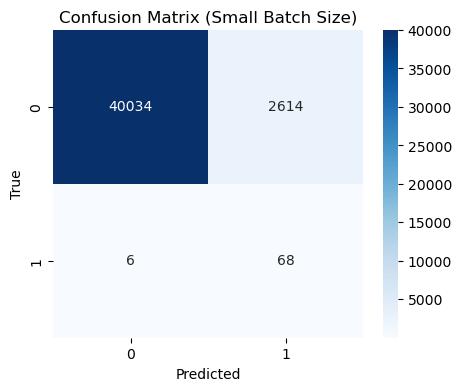

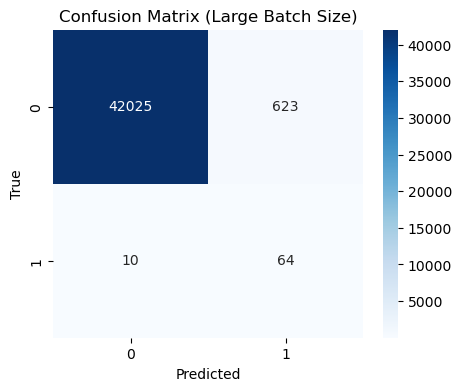

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.savefig(f"ConfusionMatrix{title}.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_cm(cm_small, "Confusion Matrix (Small Batch Size)")
plot_cm(cm_large, "Confusion Matrix (Large Batch Size)")